(xarray_intro)=
# An introduction to xarray

:::{post} July 13, 2023
:category: python, xarray
:tags: data storage, recommendation
:exclude:

Tutorial style introduction to xarray features: dimensions, coordinates, indexes, plotting and more...
:::

:::{image} ../post_images/indexing_modes.png
:alt:
:class: hidden-metadata
:::

Xarray provides two data structures: <inv:#xarray.DataArray> and <inv:#xarray.Dataset>. Both support named dimensions, coordinates and, more recently, also explicit indexes.
A `DataArray` can be seen as an extension of an n-dimensional array like a <inv:#numpy.ndarray>. A `DataSet` can be seen as an extension of a flat dictionary of arrays.

In this post we will cover dimensions, coordinates and indexes, especially for `DataArray` objects but also for `Dataset` objects. Xarray also supports attaching arbitrary metadata to `DataArray`s, `Dataset`s and even coordinates. The arrays we'll generate will have random values, so we won't care much about the values themselves, and we won't cover attributes in this post either, so we will configure the html view of xarray objects to show indexes by default and hide attributes:

In [1]:
import numpy as np
import xarray as xr

xr.set_options(display_expand_data=False, display_expand_indexes=True, display_expand_attrs=False);

## DataArray
### Dimensions
For me, the most important feature is the ability to label dimensions. Given an array, we can assign a label to each of its dimensions (axes in NumPy terminology):

In [2]:
ary = np.random.default_rng().normal(size=(4, 100, 7, 24))
da_dims = xr.DataArray(ary, dims=["chain", "draw", "person", "time"])
da_dims

<xarray.DataArray (chain: 4, draw: 100, person: 7, time: 24)>
1.164 0.8265 -0.3381 0.9449 1.98 ... -0.8126 0.5171 -1.051 -0.5774 -0.4817
Dimensions without coordinates: chain, draw, person, time

We now have the same data as in the array `ary` with its dimensions labeled. That means we can indicate operations over specific dimensions using their names instead of positional indicators. For example:

In [3]:
da_dims.mean(dim=("chain", "draw"))
# instead of ary.mean(axis=(0, 1))

<xarray.DataArray (person: 7, time: 24)>
-0.04793 -0.01097 0.03508 -0.07406 ... 0.08875 0.02561 -0.01881 -0.03173
Dimensions without coordinates: person, time

And even more, we can also sort along a specific dimension without needing to even specify any dimension nor axis. For example, to sort along the time dimension using the means of the `DataArray` we can do:

In [4]:
time_means = da_dims.mean(("chain", "draw", "person"))
da_dims.sortby(time_means)
# instead of
# order = np.argsort(ary.mean(axis=(0, 1, 2)))
# ary[..., order] 

<xarray.DataArray (chain: 4, draw: 100, person: 7, time: 24)>
0.6738 0.9679 0.9449 -0.3381 0.5381 1.98 ... 0.3212 0.7235 0.2429 0.3788 -0.4113
Dimensions without coordinates: chain, draw, person, time

As the `time_means` `DataArray` has a single dimension and it is named `time`, `.sortby` sorts along that dimension.

Having this information also allows xarray to perform automatic broadcasting:

In [5]:
da_persons = xr.DataArray(np.arange(7), dims="person")
da_dims + da_persons
# instead of ary + np.arange(13)[..., :, None]

<xarray.DataArray (chain: 4, draw: 100, person: 7, time: 24)>
1.164 0.8265 -0.3381 0.9449 1.98 -1.832 ... 6.141 5.187 6.517 4.949 5.423 5.518
Dimensions without coordinates: chain, draw, person, time

Still, for the most part, `DataArray`s are interchangeable with ndarrays, even for functions that don't support `DataArray`s explicitly:

In [6]:
np.fft.rfft(da_dims, n=8, axis=2)

array([[[[-7.05103938e-01+0.j        ,  3.20998619e+00+0.j        ,
          -3.89301708e-01+0.j        , ...,
          -3.28223564e+00+0.j        , -3.93905370e+00+0.j        ,
          -1.46815152e+00+0.j        ],
         [ 2.63681065e+00-0.63377221j, -7.24334467e-01-1.10928501j,
           7.38184144e-01-1.1649908j , ...,
          -4.85216041e-01+2.50127064j, -5.36173630e-01-3.22612384j,
          -1.80993821e+00+2.778141j  ],
         [ 8.05211921e-01-1.01508558j, -8.76457636e-01+3.17940903j,
           2.70102889e+00-2.01384215j, ...,
           1.41752605e+00-0.38687799j,  8.02449687e-01+1.61608384j,
           1.53501722e+00-0.39785814j],
         [ 3.24115984e+00+0.80562246j,  1.73609377e+00-0.98200847j,
          -1.95460231e+00-2.14114662j, ...,
           5.10215533e-01+1.0456462j , -2.93548902e+00+1.40644197j,
           2.56769326e-01+0.70846213j],
         [-3.34692097e+00+0.j        ,  3.13169766e+00+0.j        ,
          -5.28439527e+00+0.j        , ...,
        

It is possible to convert a `DataArray` to an ndarray using `da.values` but as we have just seen, very often it is not necessary.

### Coordinates and indexes
In addition, it is also possible to use coordinates. For `DataArray`s, coordinates are kind of in between data and attributes.
A `DataArray` is equivalent to a single array, however, it can have as many coordinates as desired. When creating a `DataArray`,
the `coords` argument can be used to initialize the coordinates. It is a dictionary whose keys are coordinate names,
and its values are `DataArray`s, arrays or tuples:

In [7]:
ary = np.random.default_rng().normal(size=(4, 100, 7, 24))
da = xr.DataArray(
    ary,
    dims=["chain", "draw", "person", "time"],
    coords={
        "chain": [1, 2, 3, 4],
        "gender": ("person", ["male", "neutrois", "female", "male", "NB", "female", "female"]),
        "age": ("person", [25, 30, 73, 47, 51, 20, 64]),
    }
)
da

<xarray.DataArray (chain: 4, draw: 100, person: 7, time: 24)>
-2.333 -0.9839 0.8063 1.505 -0.0909 1.33 ... -0.1766 0.484 0.1027 -0.1825 1.198
Coordinates:
  * chain    (chain) int64 1 2 3 4
    gender   (person) <U8 'male' 'neutrois' 'female' ... 'NB' 'female' 'female'
    age      (person) int64 25 30 73 47 51 20 64
Dimensions without coordinates: draw, person, time

Alternatively, <inv:#xarray.DataArray.assign_coords> can be used to add coordinates to an existing `DataArray`:

In [8]:
da = da.assign_coords(city=("person", ["Lleida", "Leida", "Sau", "Lleida", "Reus", "Sau", "Reus"]))
da

<xarray.DataArray (chain: 4, draw: 100, person: 7, time: 24)>
-2.333 -0.9839 0.8063 1.505 -0.0909 1.33 ... -0.1766 0.484 0.1027 -0.1825 1.198
Coordinates:
  * chain    (chain) int64 1 2 3 4
    gender   (person) <U8 'male' 'neutrois' 'female' ... 'NB' 'female' 'female'
    age      (person) int64 25 30 73 47 51 20 64
    city     (person) <U6 'Lleida' 'Leida' 'Sau' 'Lleida' 'Reus' 'Sau' 'Reus'
Dimensions without coordinates: draw, person, time

So far we have added all these coordinates, but we can't yet use that information directly for, say, slicing. Only the values of `chain` can be used for that,
hence it being bold in the "Coordinates" section and appearing in the "Indexes" section. To use the rest of the coordinates for slicing too, we need to 
indicate that to xarray:

In [9]:
da = da.set_xindex("gender").set_xindex("city")
da

<xarray.DataArray (chain: 4, draw: 100, person: 7, time: 24)>
-2.333 -0.9839 0.8063 1.505 -0.0909 1.33 ... -0.1766 0.484 0.1027 -0.1825 1.198
Coordinates:
  * chain    (chain) int64 1 2 3 4
  * gender   (person) <U8 'male' 'neutrois' 'female' ... 'NB' 'female' 'female'
    age      (person) int64 25 30 73 47 51 20 64
  * city     (person) <U6 'Lleida' 'Leida' 'Sau' 'Lleida' 'Reus' 'Sau' 'Reus'
Dimensions without coordinates: draw, person, time

We can slice along the `person` dimension using the `gender` coordinate:

In [10]:
da.sel(gender="female")

<xarray.DataArray (chain: 4, draw: 100, person: 3, time: 24)>
-0.2618 -0.6076 -0.4886 -0.6244 -0.1986 ... -0.1766 0.484 0.1027 -0.1825 1.198
Coordinates:
  * chain    (chain) int64 1 2 3 4
  * gender   (person) <U8 'female' 'female' 'female'
    age      (person) int64 73 20 64
  * city     (person) <U6 'Sau' 'Sau' 'Reus'
Dimensions without coordinates: draw, person, time

### Vectorized and outer indexing
NumPy indexing is extremely powerful, especially what is often called "fancy" indexing. However, it can be confusing and inconsistent (see [this NEP proposal](https://numpy.org/neps/nep-0021-advanced-indexing.html) for more background). With dimensions and coordinates, xarray allows being explicit and consistent when choosing between vectorized and outer indexing.

![Diagram showing visually the two indexing modes. With outer indexing, we select the intersection between the slice in each dimension. With vectorized indexing we select only the specific positions indicated by the pointwise combination of indexes.](../post_images/indexing_modes.png)

Outer indexing selects rectangular or hyper-rectangular slices. To use outer indexing with xarray, we can use lists, arrays or _`DataArray`s that have as a dimension the one that is being indexed_. Therefore, the output of outer indexing will have the same dimensions as the input minus those dimensions whose slice is a scalar, which are squeezed.

In [11]:
da.sel(chain=[1, 3], time=slice(0, 5))

<xarray.DataArray (chain: 2, draw: 100, person: 7, time: 5)>
-2.333 -0.9839 0.8063 1.505 -0.0909 ... -0.2397 0.4177 0.9724 1.131 0.3541
Coordinates:
  * chain    (chain) int64 1 3
  * gender   (person) <U8 'male' 'neutrois' 'female' ... 'NB' 'female' 'female'
    age      (person) int64 25 30 73 47 51 20 64
  * city     (person) <U6 'Lleida' 'Leida' 'Sau' 'Lleida' 'Reus' 'Sau' 'Reus'
Dimensions without coordinates: draw, person, time

Vectorized indexing selects only the exact positions being indicated by the indexing arrays. To do that we have to use _`DataArray`s with dimensions different than those being indexed_. As long as all index `DataArray`s have the same dimensions (and thus shape) they can also be multidimensional. Therefore, the output of vectorized indexing will have as dimensions, all the dimensions in the indexes, and all the dimensions that were not indexed:

In [12]:
chain_idx = xr.DataArray([1, 1, 3, 3, 1, 3, 1, 1], dims="vectorized_sel")
time_idx = xr.DataArray([0, 1, 0, 1, 2, 2, 3, 4], dims="vectorized_sel")
da.sel(chain=chain_idx, time=time_idx)

<xarray.DataArray (vectorized_sel: 8, draw: 100, person: 7)>
-2.333 -0.9922 -0.2618 0.7559 1.352 ... 0.4422 1.155 0.4988 -0.4919 -0.3735
Coordinates:
    chain    (vectorized_sel) int64 1 1 3 3 1 3 1 1
  * gender   (person) <U8 'male' 'neutrois' 'female' ... 'NB' 'female' 'female'
    age      (person) int64 25 30 73 47 51 20 64
  * city     (person) <U6 'Lleida' 'Leida' 'Sau' 'Lleida' 'Reus' 'Sau' 'Reus'
Dimensions without coordinates: vectorized_sel, draw, person

### Plotting
Xarray also has some plotting support, which is very convenient for visualizing the multidimensional data. For example, we can facet over a 1st dimension (here `chain`,
use a 2nd dimension (here `time`) as x values of the line plot and map the color of the lines to a 3rd dimension (here `person`). 
The y values are the actual values in the `DataArray`.

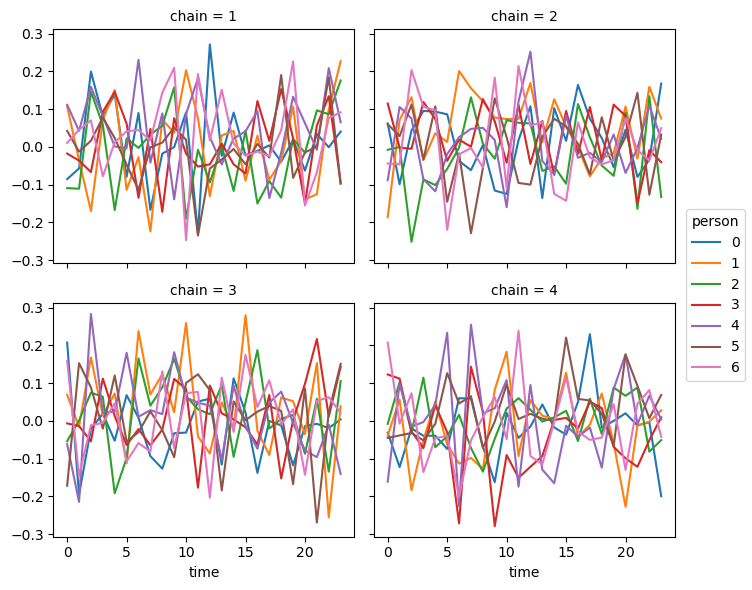

In [13]:
da.mean("draw").plot.line(x="time", hue="person", col="chain", col_wrap=2);

or, we can visualize a 2d slice of the data, with the values mapped to the color via a colormap using `imshow`.

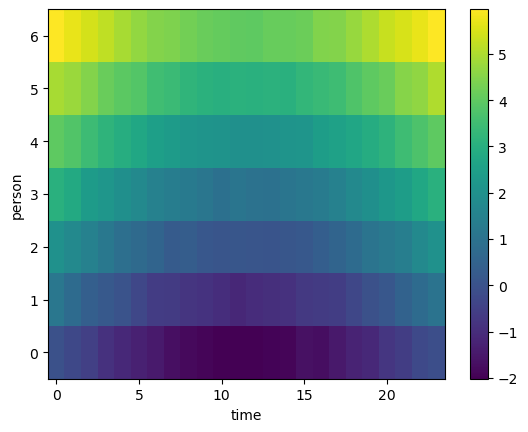

In [14]:
# make the plot more interesting
da_plot = da_dims + da_persons - xr.DataArray(2*np.sin(np.linspace(0, np.pi, 24)), dims="time")
da_plot.mean(("chain", "draw")).plot.imshow(x="time", y="person", center=False);

## Dataset
`Dataset`s are a collection of `DataArray`s, each `DataArray` being a data variable and having a name/key. Thus, they are similar to a dictionary of arrays but with one important difference. Dimensions with the same name are shared between variables:

In [15]:
ds = xr.Dataset(
    {
        "a": (["chain", "draw", "person", "time"], ary),
        "b": (["chain", "draw"], np.random.default_rng().normal(size=(4, 100)))
    },
    coords={"chain": [1, 2, 3, 4]}
)
ds

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 100, person: 7, time: 24)
Coordinates:
  * chain    (chain) int64 1 2 3 4
Dimensions without coordinates: draw, person, time
Data variables:
    a        (chain, draw, person, time) float64 -2.333 -0.9839 ... 1.198
    b        (chain, draw) float64 -0.9367 0.5736 -0.3545 ... -0.2987 -0.5123

They work very similarly to `DataArray`s, with operations being applied to all data variables in the `Dataset` (if reasonable). For example, if we index along the chain dimension, the operation applies to all two variables. However, taking the mean over the person dimension only affects the data variable `a`:

In [16]:
ds.sel(chain=2).mean("person")

<xarray.Dataset>
Dimensions:  (draw: 100, time: 24)
Coordinates:
    chain    int64 2
Dimensions without coordinates: draw, time
Data variables:
    a        (draw, time) float64 -0.1994 -0.6486 -0.1148 ... 0.4029 0.2966
    b        (draw) float64 -0.4077 2.132 2.622 -2.868 ... -1.39 0.2419 1.659

To apply arbitrary functions to all the data variables in a `Dataset`, we can use <inv:#xarray.Dataset.map> for functions that return a `DataArray` or <inv:#xarray.apply_ufunc> for functions that return arrays. `apply_ufunc` can be challenging to use, but there is a good chance that a library exists that already wraps and extends numpy/scipy/... functions to have an xarray-like API. Take a look at <inv:xarray:*:doc#ecosystem> to browse packages that extend xarray.

And if this still doesn't work, yet again, `Dataset`s are quite like a dictionary. So much so that they even have a [dict-like interface](https://docs.xarray.dev/en/stable/api.html#dictionary-interface) with `.items()`, `.keys()`, `.get()`...

I hope this introduction has been useful. I would like to continue exploring features of xarray as a series, also covering potential new features and extensions for ArviZ. You can leave your comments to this blog post below, only a GitHub account is needed for commenting.

---

Package versions used to generate this post:

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jul 13 2023

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

xarray: 2023.6.0
numpy : 1.24.4

Watermark: 2.4.3



---

Lastly, as an appendix, you can expand the dropdown below to see the code used to generate the vectorized vs outer index diagram.

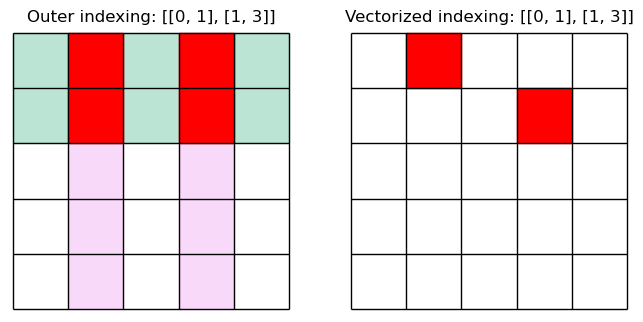

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.fill_betweenx([3, 5], x1=5, x2=0, color="xkcd:jade", alpha=.3)
ax.fill_between([1, 2], y1=5, y2=0, color="violet", alpha=.3)
ax.fill_between([3, 4], y1=5, y2=0, color="violet", alpha=.3)
ax.fill_between([1, 2], y1=5, y2=3, color="r")
ax.fill_between([3, 4], y1=5, y2=3, color="r")
ax.hlines(np.arange(6), 0, 5, lw=1, color="k")
ax.vlines(np.arange(6), 0, 5, lw=1, color="k")
ax.set_ylim(-0.05, 5.05)
ax.set_xlim(-0.05, 5.05)
ax.set_title("Outer indexing: [[0, 1], [1, 3]]")
ax.set_axis_off()
ax.set_aspect("equal")

ax = axes[1]
ax.fill_between([1, 2], y1=5, y2=4, color="r")
ax.fill_between([3, 4], y1=4, y2=3, color="r")
ax.hlines(np.arange(6), 0, 5, lw=1, color="k")
ax.vlines(np.arange(6), 0, 5, lw=1, color="k")
ax.set_ylim(-0.05, 5.05)
ax.set_xlim(-0.05, 5.05)
ax.set_title("Vectorized indexing: [[0, 1], [1, 3]]")
ax.set_axis_off()
ax.set_aspect("equal")

#fig.savefig("indexing_modes.png", dpi=300)